# This is an example of querying images from the database

## Import Essential Libraries

In [1]:
import tensorflow as tf

import random

import numpy as np

import h5py

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.util import random_noise

from model import VGGNet

## Load Dataset

In [2]:
datasets = h5py.File('features.h5', 'r')
features = datasets['features'][:]
image_ids = datasets['image_ids'][:]
datasets.close()

## Load Model

In [3]:
model = VGGNet()

1/1 [==============================] - 2s 2s/step


## Query Images

### Querying without any modification

#### Get a image to test without any modification

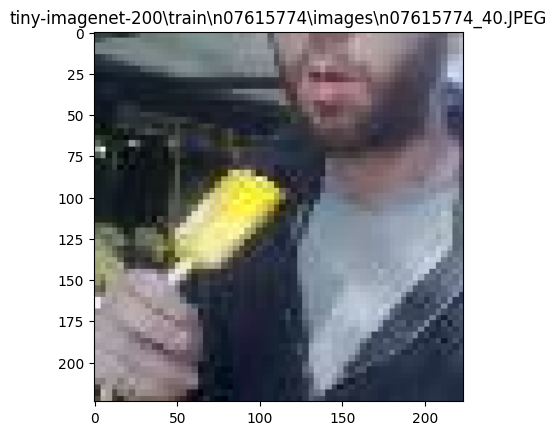

In [4]:
query_img_path = image_ids.astype(str)[random.randint(0, len(image_ids))]
query_img = tf.keras.utils.load_img(query_img_path, target_size=(model.input_shape[0], model.input_shape[1]))
query_img = tf.keras.utils.img_to_array(query_img)

plt.title(query_img_path)
plt.imshow(query_img.astype(int))
plt.show()

#### Query the image from all of the images in the dataset

In [5]:
query_feature = model.extract_feature(query_img)
scores = np.dot(query_feature, features.T)
rank_ID = np.argsort(scores)[::-1]
rank_score = scores[rank_ID]

1/1 [==============================] - 0s 16ms/step


In [6]:
imlist = [image_ids.astype(str)[index] for i, index in enumerate(rank_ID[0:10])]
print("top %d images in order are:" % 10, '\n' + '\n'.join(imlist))

top 10 images in order are: 
tiny-imagenet-200\train\n07615774\images\n07615774_40.JPEG
tiny-imagenet-200\train\n04540053\images\n04540053_101.JPEG
tiny-imagenet-200\train\n02917067\images\n02917067_208.JPEG
tiny-imagenet-200\train\n03992509\images\n03992509_493.JPEG
tiny-imagenet-200\train\n01770393\images\n01770393_352.JPEG
tiny-imagenet-200\train\n02056570\images\n02056570_393.JPEG
tiny-imagenet-200\train\n04376876\images\n04376876_37.JPEG
tiny-imagenet-200\train\n02056570\images\n02056570_188.JPEG
tiny-imagenet-200\train\n07615774\images\n07615774_166.JPEG
tiny-imagenet-200\train\n02165456\images\n02165456_195.JPEG


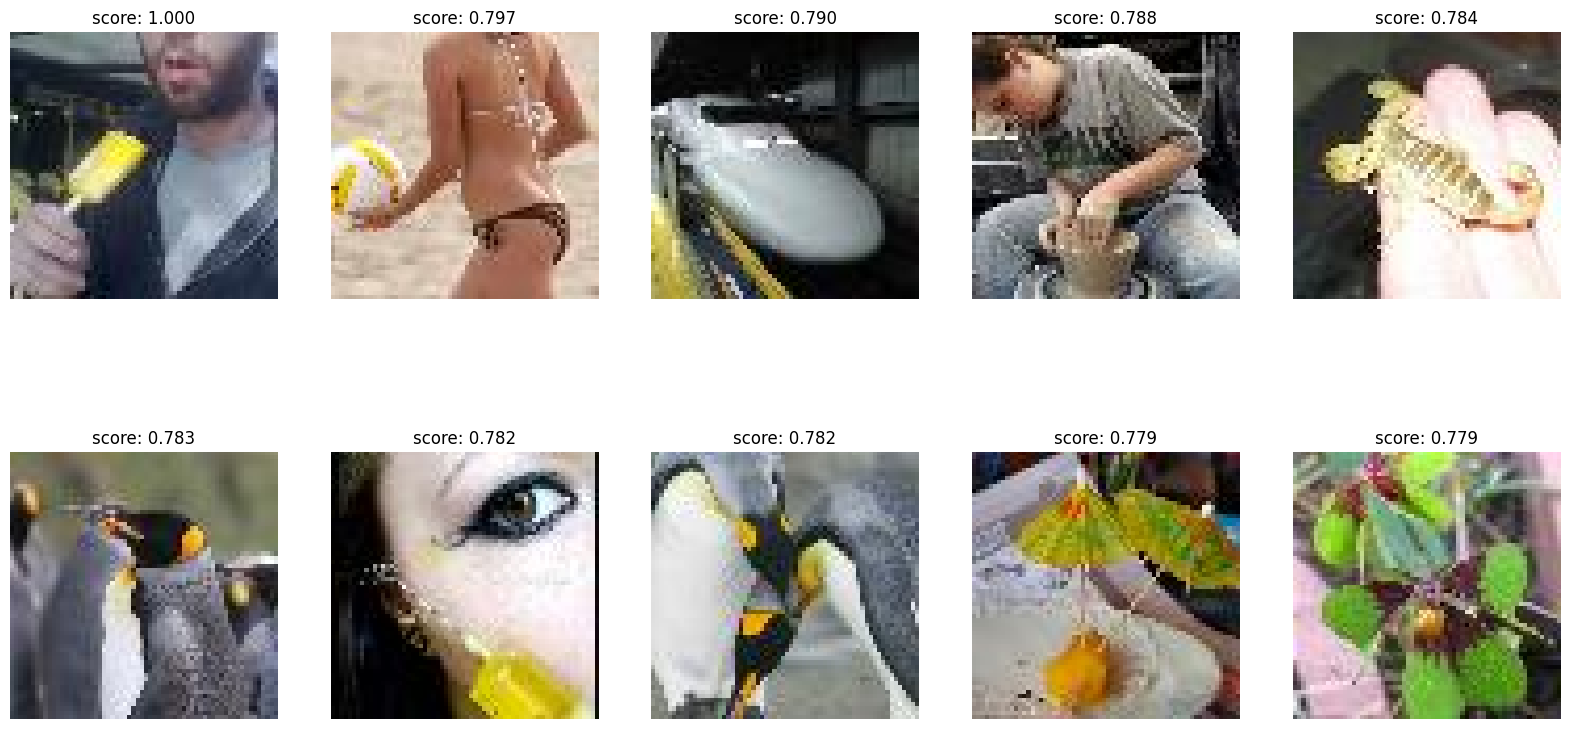

In [7]:
# draw top 10 images
plt.figure(figsize=(20, 10))
for i, im in enumerate(imlist):
    image = mpimg.imread(im)
    plt.subplot(2, 5, i+1)
    plt.title(f'score: {rank_score[i]:.3f}')
    plt.imshow(image)
    plt.axis('off')

### Querying with Gaussian noise

#### Get a image to test randomly with Gaussian noise

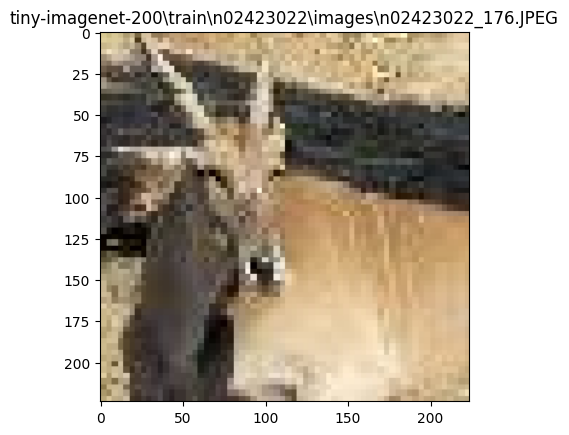

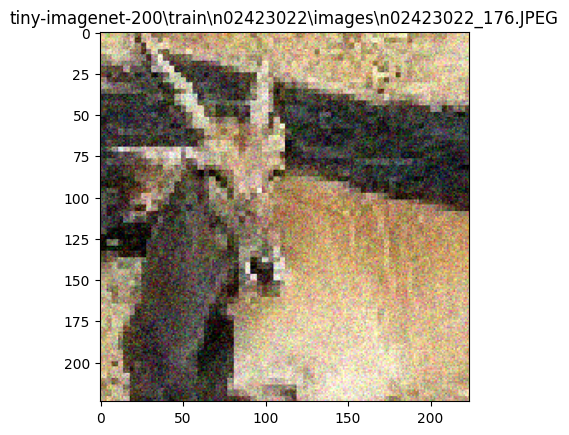

In [8]:
query_img_path = image_ids.astype(str)[random.randint(0, len(image_ids))]
query_img = tf.keras.utils.load_img(query_img_path, target_size=(model.input_shape[0], model.input_shape[1]))
query_img = tf.keras.utils.img_to_array(query_img)

plt.title(query_img_path)
plt.imshow(query_img.astype(int))
plt.show()

# Gaussian noise
query_img = random_noise(query_img / 255, mode='gaussian', clip=True)
query_img = np.array(query_img * 255, dtype=np.uint8)

plt.title(query_img_path)
plt.imshow(query_img.astype(int))
plt.show()

#### Query the image from all of the images in the dataset

In [9]:
query_feature = model.extract_feature(query_img)
scores = np.dot(query_feature, features.T)
rank_ID = np.argsort(scores)[::-1]
rank_score = scores[rank_ID]

1/1 [==============================] - 0s 18ms/step


In [10]:
imlist = [image_ids.astype(str)[index] for i, index in enumerate(rank_ID[0:10])]
print("top %d images in order are:" % 10, '\n' + '\n'.join(imlist))

top 10 images in order are: 
tiny-imagenet-200\train\n02423022\images\n02423022_176.JPEG
tiny-imagenet-200\train\n02769748\images\n02769748_403.JPEG
tiny-imagenet-200\train\n02113799\images\n02113799_205.JPEG
tiny-imagenet-200\train\n02948072\images\n02948072_41.JPEG
tiny-imagenet-200\train\n02132136\images\n02132136_419.JPEG
tiny-imagenet-200\train\n02504458\images\n02504458_42.JPEG
tiny-imagenet-200\train\n04133789\images\n04133789_266.JPEG
tiny-imagenet-200\train\n07614500\images\n07614500_11.JPEG
tiny-imagenet-200\train\n02486410\images\n02486410_231.JPEG
tiny-imagenet-200\train\n09246464\images\n09246464_248.JPEG


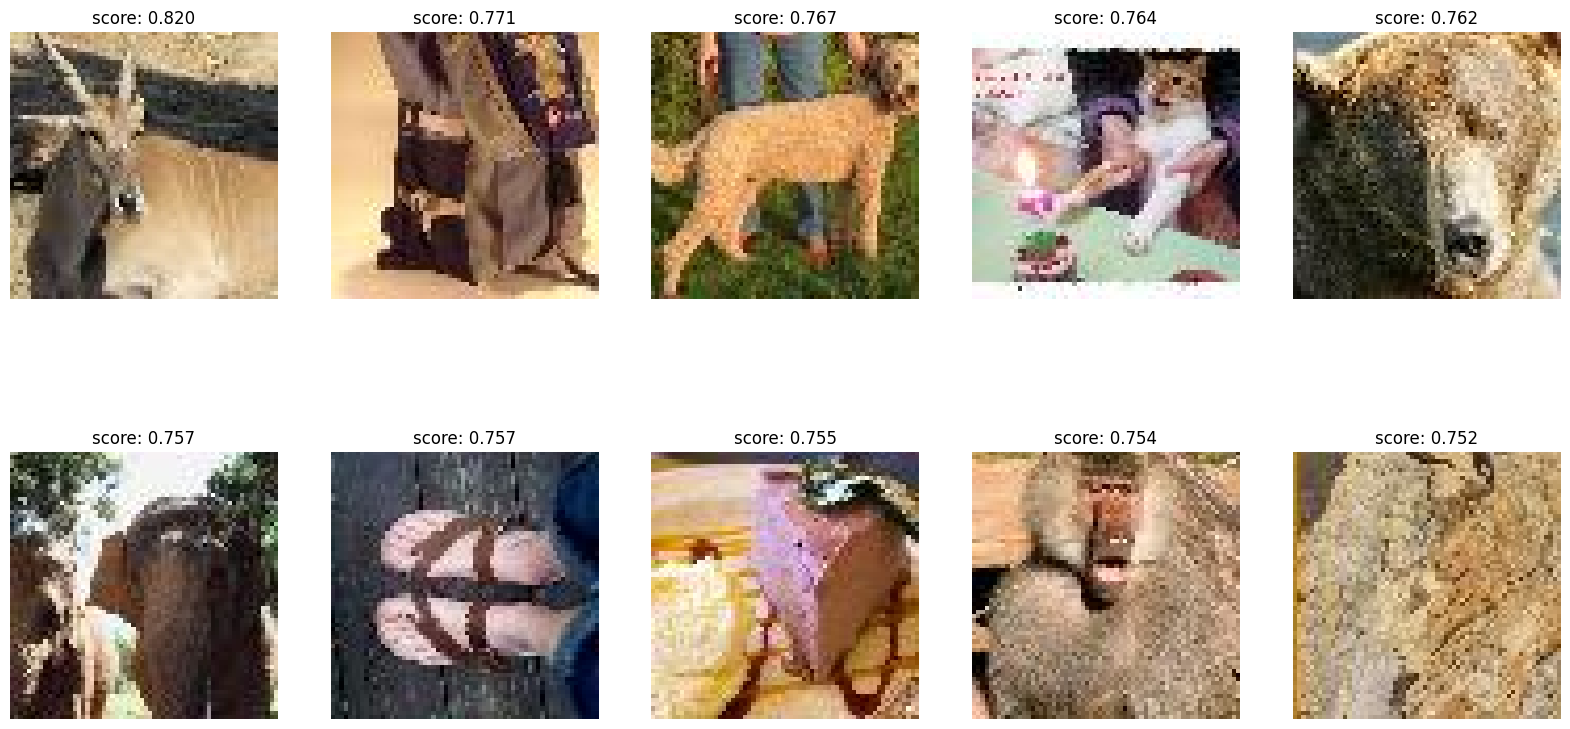

In [11]:
# draw top 10 images
plt.figure(figsize=(20, 10))
for i, im in enumerate(imlist):
    image = mpimg.imread(im)
    plt.subplot(2, 5, i+1)
    plt.title(f'score: {rank_score[i]:.3f}')
    plt.imshow(image)
    plt.axis('off')

### Use clustering to reduce the number of images to be queried

In [12]:
import pandas as pd
from sklearn.cluster import KMeans

#### Cluster the images in the dataset

I'm going to use K-means clustering with 10 clusters.

In [13]:
X = features
kmeans = KMeans(n_clusters=10, random_state=0, n_init='auto', verbose=0).fit(X)

##### If you want show the Elbow method and Silhouette method graphs, uncomment the following cells.

In [14]:
# K = range(1, 20)
# KM = [KMeans(n_clusters=k, random_state=0).fit(X) for k in K]

In [15]:
# plt.plot(K, [km.inertia_ for km in KM], 'bx-')
# plt.xlabel('k')
# plt.ylabel('inertia')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()

In [16]:
# from sklearn.metrics import silhouette_score
# plt.plot(K, [silhouette_score(X, km.labels_) for km in KM[1:]], 'bx-')
# plt.xlabel('k')
# plt.ylabel('silhouette score')
# plt.title('The Silhouette Method showing the optimal k')
# plt.show()

In [17]:
kmeans.labels_

array([2, 5, 1, ..., 5, 3, 5])

##### Predict query image's cluster

In [18]:
predict = kmeans.predict(query_feature.reshape(1, -1))
predict

array([0])

##### Get the images in the same cluster with the query image

In [19]:
df = pd.DataFrame({'image_id': image_ids.astype(str), 'cluster_id': kmeans.labels_})
df.head()

,image_id,cluster_id
0,tiny-imagenet-200\train\n02410509\images\n0241...,2
1,tiny-imagenet-200\train\n03255030\images\n0325...,5
2,tiny-imagenet-200\train\n01443537\images\n0144...,1
3,tiny-imagenet-200\train\n04259630\images\n0425...,9
4,tiny-imagenet-200\train\n02410509\images\n0241...,0


In [20]:
df[df['cluster_id'] == predict[0]].head()

,image_id,cluster_id
4,tiny-imagenet-200\train\n02410509\images\n0241...,0
16,tiny-imagenet-200\train\n02410509\images\n0241...,0
20,tiny-imagenet-200\train\n02410509\images\n0241...,0
24,tiny-imagenet-200\train\n02410509\images\n0241...,0
28,tiny-imagenet-200\train\n02410509\images\n0241...,0


In [21]:
query = df[df['cluster_id'] == predict[0]].index
# get fetures item by index
features[query]

array([[0.02766944, 0.        , 0.13998699, ..., 0.        , 0.00262588,
        0.01440641],
       [0.        , 0.        , 0.07453955, ..., 0.        , 0.09490738,
        0.05410904],
       [0.02882438, 0.        , 0.04563225, ..., 0.        , 0.01518378,
        0.06184997],
       ...,
       [0.10338689, 0.        , 0.0714692 , ..., 0.        , 0.01828102,
        0.04311742],
       [0.02378029, 0.        , 0.01527129, ..., 0.        , 0.01918783,
        0.07083332],
       [0.08157574, 0.        , 0.05661192, ..., 0.        , 0.08069754,
        0.        ]], dtype=float32)

##### The querying image is the image used in the Gaussian noise section.

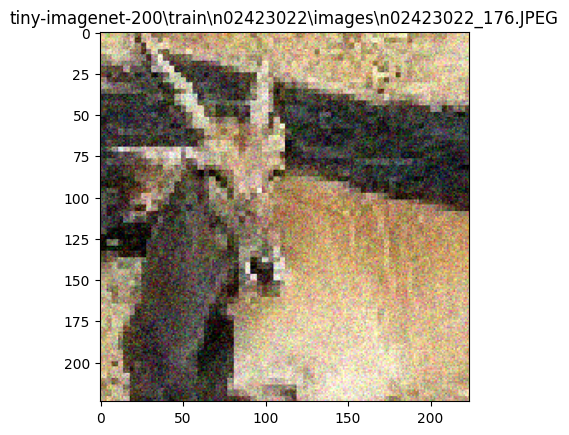

In [22]:
# query_img
plt.title(query_img_path)
plt.imshow(query_img.astype(int))
plt.show()

##### Query the image from the images in the same cluster

In [23]:
query_feature = model.extract_feature(query_img)
scores = np.dot(query_feature, features[query].T)
rank_ID = np.argsort(scores)[::-1]
rank_score = scores[rank_ID]

1/1 [==============================] - 0s 16ms/step


The dataset had reduced from 100k images to about 10k images.

In [24]:
scores.shape

(10251,)

In [25]:
scores

array([0.6876404 , 0.6717842 , 0.6289435 , ..., 0.648251  , 0.66733533,
       0.63301754], dtype=float32)

In [26]:
rank_ID

array([ 557, 6312, 8026, ...,  608,  523,  761], dtype=int64)

In [27]:
rank_score

array([0.82029706, 0.76729393, 0.7615188 , ..., 0.46768105, 0.45497885,
       0.44008666], dtype=float32)

In [28]:
imlist = [image_ids.astype(str)[index] for i, index in enumerate(query[rank_ID[0:10]])]
print("top %d images in order are:" % 10, '\n' + '\n'.join(imlist))

top 10 images in order are: 
tiny-imagenet-200\train\n02423022\images\n02423022_176.JPEG
tiny-imagenet-200\train\n02113799\images\n02113799_205.JPEG
tiny-imagenet-200\train\n02132136\images\n02132136_419.JPEG
tiny-imagenet-200\train\n02504458\images\n02504458_42.JPEG
tiny-imagenet-200\train\n04133789\images\n04133789_266.JPEG
tiny-imagenet-200\train\n02486410\images\n02486410_231.JPEG
tiny-imagenet-200\train\n09246464\images\n09246464_248.JPEG
tiny-imagenet-200\train\n02486410\images\n02486410_21.JPEG
tiny-imagenet-200\train\n02437312\images\n02437312_391.JPEG
tiny-imagenet-200\train\n12267677\images\n12267677_398.JPEG


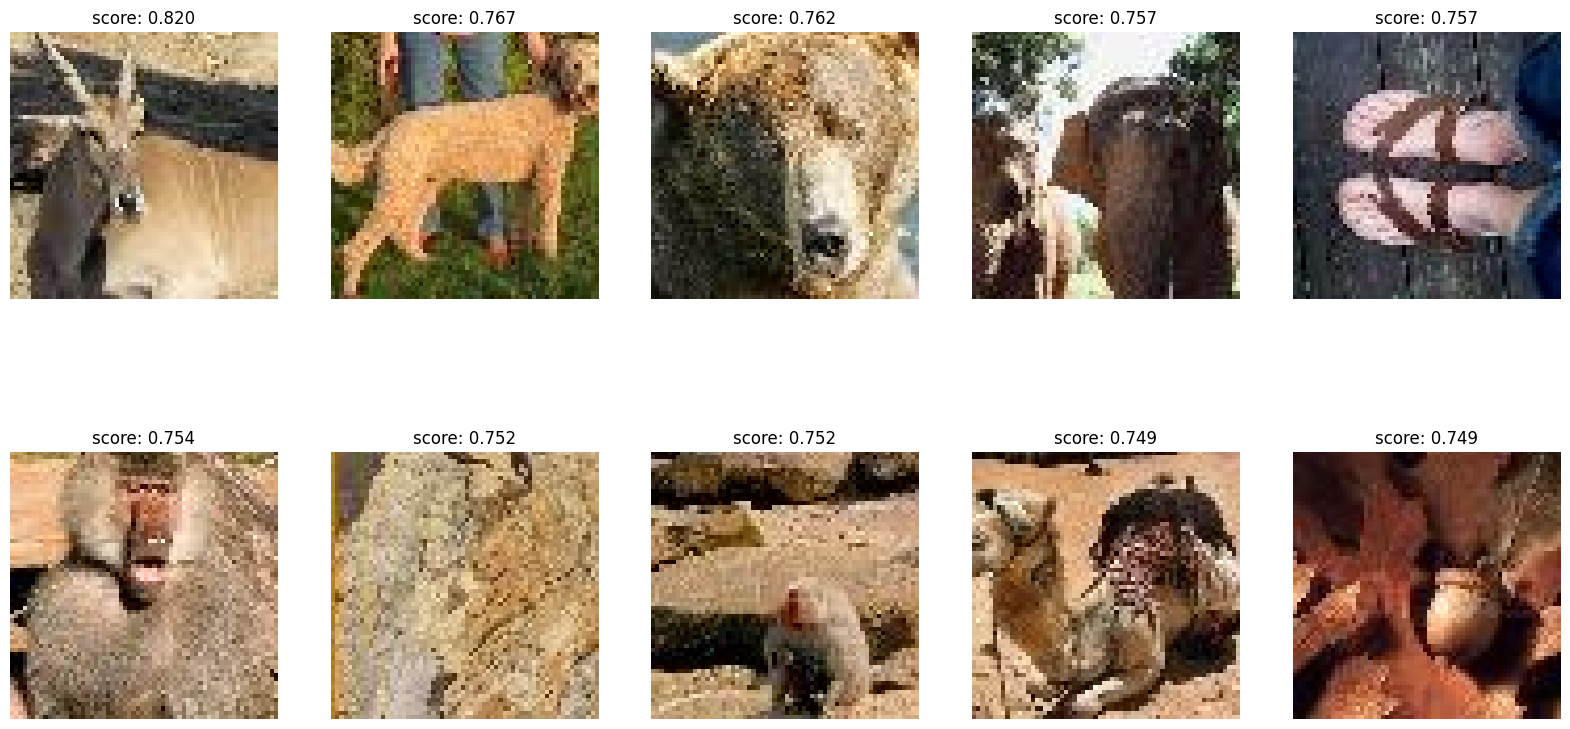

In [29]:
# draw top 10 images
plt.figure(figsize=(20, 10))
for i, im in enumerate(imlist):
    image = mpimg.imread(im)
    plt.subplot(2, 5, i+1)
    plt.title(f'score: {rank_score[i]:.3f}')
    plt.imshow(image)
    plt.axis('off')